In [59]:
import os
import numpy as np
from glob import glob
import soundfile as sf
from matplotlib import pyplot as plt
from pydub import AudioSegment
from tqdm import tqdm
import librosa
from scipy.io import wavfile
from random import shuffle

%matplotlib inline

In [62]:
data_directory = 'dev-clean'
destination_directory = 'prep-train-clean'
if not os.path.isdir(destination_directory):
    os.mkdir(destination_directory)
    os.mkdir(destination_directory + '/train')
    os.mkdir(destination_directory + '/val')
    
sub_dirs = list()
for root,dirs,files in os.walk(data_directory):
    if not dirs:
        sub_dirs.append(root)

In [63]:
all_files = []
all_targets = []
all_targets_length = []
durations = []
for sdir in tqdm(sub_dirs):
    flac_files = glob(sdir + '/*.flac')
    
    targ_file = glob(sdir + '/*.txt')[0]
    with open(targ_file) as f:
        targ_file_content = f.readlines()
    all_wav_files = []
    for file in flac_files:
        data, sr = sf.read(file)
        durations.append(data.shape[0]/16000)
        fname = file[-9:-5]
        t_line = [con.split('-')[2][5:] for con in targ_file_content if con.split('-')[2][:4] == fname][0]
        t_line = t_line.replace('\n', '')
        t_line = t_line.replace("'", '')
        all_targets.append(t_line.lower())
        all_targets_length.append(len(t_line))
        
        # convert to wav
        fname_split = file.split('/')
        wav_fname = '/'.join(fname_split[:-1]) + '/' + fname_split[-1][:-4] + 'wav'
        if not os.path.isfile(wav_fname):
            audio = AudioSegment.from_file(file, extension='flac')
            audio.export(wav_fname, format = "wav")
        all_wav_files.append(wav_fname)
        
    all_files += all_wav_files
    
durations = np.array(durations)

100%|██████████| 97/97 [00:14<00:00,  6.87it/s]


In [64]:
all_files[:3]

['dev-clean/LibriSpeech/dev-clean/84/121123/84-121123-0013.wav',
 'dev-clean/LibriSpeech/dev-clean/84/121123/84-121123-0023.wav',
 'dev-clean/LibriSpeech/dev-clean/84/121123/84-121123-0012.wav']

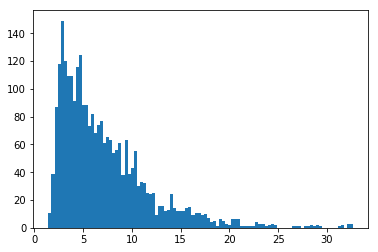

In [65]:
plt.figure()
plt.hist(durations, bins=100)
plt.show()

In [66]:
# here you can pick the appropriate audio duration by looking at how mfcc shape would look like
# e.g. 5.11secs will result in (16,320) which is good

# all audios that are shorter than 5.11 will be padded to 5.11

### CHANGE THIS
audio_duration_secs = 15.35
###

audio_duration_samples = int(audio_duration_secs * 16000)

mfcc = librosa.feature.mfcc(
    y=np.zeros(audio_duration_samples),
    sr=16000, 
    n_fft=2048,
    hop_length=256,
    n_mfcc=16,
    n_mels=128,
    fmin=0,
    fmax=8000)

# needs to be divisible by 16
N_samples = durations[durations <= audio_duration_secs].shape[0]
T = mfcc.T.shape[0]
print("MFCC shape would be", mfcc.T.shape)
print("Number of training samples would be", N_samples)

MFCC shape would be (960, 16)
Number of training samples would be 2524


In [67]:
# Filter for duration
all_files_good = [all_files[i] for i in range(len(all_files)) if durations[i] <= audio_duration_secs]
all_targets_good = [all_targets[i] for i in range(len(all_files)) if durations[i] <= audio_duration_secs]
all_targets_length_good = [all_targets_length[i] for i in range(len(all_files)) if durations[i] <= audio_duration_secs]

# Train / validation split
N = len(all_files_good)
Nv = int(0.2*N)
Nt = N - Nv
val_idx = np.random.choice(range(N), size=Nv, replace=False)
all_files_train = [all_files_good[i] for i in range(len(all_files_good)) if i not in val_idx]
all_files_val = [all_files_good[i] for i in range(len(all_files_good)) if i in val_idx]
all_targets_train = [all_targets_good[i] for i in range(len(all_files_good)) if i not in val_idx]
all_targets_val = [all_targets_good[i] for i in range(len(all_files_good)) if i in val_idx]
all_targets_length_train = [all_targets_length_good[i] for i in range(len(all_files_good)) if i not in val_idx]
all_targets_length_val = [all_targets_length_good[i] for i in range(len(all_files_good)) if i in val_idx]

# shuffle all arrays:
stidx = list(np.arange(Nt))
shuffle(stidx)
svidx = list(np.arange(Nv))
shuffle(svidx)

all_files_train = [all_files_train[i] for i in stidx]
all_files_val = [all_files_val[i] for i in svidx]
all_targets_train = [all_targets_train[i] for i in stidx]
all_targets_val = [all_targets_val[i] for i in svidx]
all_targets_length_train = [all_targets_length_train[i] for i in stidx]
all_targets_length_val = [all_targets_length_val[i] for i in svidx]

In [68]:
print('Number training samples: ' + str(Nt))
print('Number validation samples: ' + str(Nv))

Number training samples: 2020
Number validation samples: 504


In [69]:
# Util functions

char_map_str = "' abcdefghijklmnopqrstuvwxyz"

char_map = {}
index_map = {}
index = 0
for letter in char_map_str:
    char_map[letter] = index
    index_map[index + 1] = letter
    index += 1

def text_to_int_sequence(text):
    """ Convert text to an integer sequence """
    return [char_map[_] for _ in text]

def int_sequence_to_text(int_sequence):
    """ Convert an integer sequence to text """
    text = []
    for c in int_sequence:
        ch = index_map[c]
        text.append(ch)
    return text

def get_chunk_sizes(N, chunk_size):
    full = int(N/chunk_size)
    ch_sizes = [chunk_size for i in range(full)]
    diff = N - full*chunk_size
    if diff != 0:
        ch_sizes.append(diff)
    return ch_sizes

In [70]:
merge = True

chunk_size = 1024

max_len_target = max(all_targets_length_good)

# training 
chunk_sizes = get_chunk_sizes(Nt, chunk_size)
print('Number of chunks: ' + str(len(chunk_sizes)))
if merge:
    files = glob(destination_directory + '/train/*[0-9].npy')
    nr = [int(f.split('/')[-1].split('.')[0]) for f in files]
    print('original k: ' + str(max(nr)))
    k = max(nr) + 1
else:
    k = 0
for ch in chunk_sizes:
    
    batch_x = np.zeros((ch, T, 16))
    batch_x_len = np.zeros(ch, dtype=np.int)
    batch_y = np.ones((ch, max_len_target))*28
    batch_y_len = np.zeros(ch, dtype=np.int)
    
    for i in range(ch):
        
        # features
        file = all_files_train.pop(0)
        target_txt = all_targets_train.pop(0)
        
        
        print(wavfile.read(file)[1].astype(np.float))
        mfcc = librosa.feature.mfcc(
            y=wavfile.read(file)[1].astype(np.float),
            sr=16000,
            n_fft=2048,
            hop_length=256,
            n_mfcc=16,
            n_mels=128,
            fmin=0,
            fmax=8000
        ).T
        
        
        
        assert mfcc.shape[0] <= T
        
        # normalize
        mean = mfcc.mean(axis=0)
        std = mfcc.std(axis=0)
        mfcc_norm = (mfcc - mean)/std
        
        
        batch_x[i, :mfcc.shape[0]] = mfcc_norm
        batch_x_len[i] = mfcc.shape[0]
        batch_y_len[i] = all_targets_length_train.pop(0)
        batch_y[i, :batch_y_len[i]] = text_to_int_sequence(target_txt)
        
#     print('Saving chunk ' + str(k))
#     np.save(destination_directory + '/train/' + str(k) + '.npy', batch_x)
#     np.save(destination_directory + '/train/' + str(k) + '_len.npy', batch_x_len)
#     np.save(destination_directory + '/train/' + str(k) + '_target.npy', batch_y)
#     np.save(destination_directory + '/train/' + str(k) + '_target_len.npy', batch_y_len)
    k += 1
    
    
# validation 
chunk_sizes = get_chunk_sizes(Nv, chunk_size)
print('Number of chunks: ' + str(len(chunk_sizes)))
if merge:
    files = glob(destination_directory + '/val/*[0-9].npy')
    nr = [int(f.split('/')[-1].split('.')[0]) for f in files]
    print('original k: ' + str(max(nr)))
    k = max(nr) + 1
else:
    k = 0
for ch in chunk_sizes:
    
    batch_x = np.zeros((ch, T, 16))
    batch_x_len = np.zeros(ch, dtype=np.int)
    batch_y = np.ones((ch, max_len_target))*28
    batch_y_len = np.zeros(ch, dtype=np.int)
    
    for i in range(ch):
        
        # features
        file = all_files_val.pop(0)
        target_txt = all_targets_val.pop(0)
        
        mfcc = librosa.feature.mfcc(
            y=wavfile.read(file)[1].astype(np.float),
            sr=16000,
            n_fft=2048,
            hop_length=256,
            n_mfcc=16,
            n_mels=128,
            fmin=0,
            fmax=8000
        ).T
        
        assert mfcc.shape[0] <= T
        
        # normalize
        mean = mfcc.mean(axis=0)
        std = mfcc.std(axis=0)
        mfcc_norm = (mfcc - mean)/std
        
        batch_x[i, :mfcc.shape[0]] = mfcc_norm
        batch_x_len[i] = mfcc.shape[0]
        batch_y_len[i] = all_targets_length_val.pop(0)
        batch_y[i, :batch_y_len[i]] = text_to_int_sequence(target_txt)
        
#     print('Saving chunk ' + str(k))
#     np.save(destination_directory + '/val/' + str(k) + '.npy', batch_x)
#     np.save(destination_directory + '/val/' + str(k) + '_len.npy', batch_x_len)
#     np.save(destination_directory + '/val/' + str(k) + '_target.npy', batch_y)
#     np.save(destination_directory + '/val/' + str(k) + '_target_len.npy', batch_y_len)
    k += 1

Number of chunks: 2
original k: 189
[-29. -31. -25. ... -54. -53. -66.]
[ 12.  13.   0. ... -19. -25. -21.]
[-299. -207.  -33. ...    9.   36.   41.]
[-105.  -28.   68. ...   -5.    1.   11.]
[23. 19. 11. ... -4. -8. -5.]
[ 15.  11.  16. ... -13. -48. -57.]
[0. 0. 0. ... 0. 0. 0.]
[ -96.  -96.  -44. ...   44. -160. -196.]
[153.  74.  -9. ...  57.   3.  81.]
[-167. -168. -178. ...  -43.  -35.  -18.]
[24. 16. 17. ... -1.  8.  8.]
[  7. -13. -24. ...  20.  20.   1.]
[-264. -470. -540. ...   15. -111.   52.]
[23. 45. 50. ...  2.  2.  3.]
[ 6. 10.  9. ... -4. -2. -4.]
[-12.  -8.  -2. ... -45. -46. -48.]
[ 2. 13. 16. ... -3. -3.  1.]
[45. 43. 46. ... 23. 29. 30.]
[ 23.  12.  15. ... -40. -48. -50.]
[  -8.   -9.  -10. ... -174. -174. -174.]
[-29. -25. -23. ...  25.  36.  35.]
[25. 21. 11. ... 16.  6. -2.]
[-40. -45. -43. ...  -4.   1.  -2.]
[-36. -19.  -3. ...   2.   2.   1.]
[ 78.  65. -59. ...  42.  62.  12.]
[-161.   27.   78. ...   -3.    9.   12.]
[20.  5.  7. ... 12. 16. 19.]
[-49. -32.

KeyboardInterrupt: 